# Paint by numbers image generator
Paint by number or painting by numbers are kits having a board on which light markings to indicate areas to paint, and each area has a number and a corresponding numbered paint to use. The kits come with little compartmentalised boxes where the numbered colour pigments are stored. [[WIKI]](https://en.wikipedia.org/wiki/Paint_by_number)

This notebook takes advantage of the concept of [SLIC superpixels](https://www.epfl.ch/labs/ivrl/research/slic-superpixels/) to segment a given image into n-groups of pixels that are both similar in color and connected to each other. This results into similar areas to paint as in the original paint by numbers images. The properties of these segements can be asjusted by some params that will be explained later.

Furthermore these segments are then used to construct a Region Adjacency Graph (RAG) which connects adjacent regons of an image and compairs their mean color values. Connected regions with a low differences will be joined to form one superpixel.




## Setup

In [ ]:
# loading libraries
from skimage import segmentation, color, io
from skimage.future import graph
from skimage.transform import rescale, resize
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from sklearn.cluster import KMeans
from skimage.future import graph
from matplotlib import pyplot as plt
from io import BytesIO
from PIL import Image
from ipywidgets import FileUpload
from IPython.display import display
from collections import Counter
import numpy as np

In [ ]:
# upload for own image
upload = FileUpload(accept='image/*')
print("please upload an image here")
display(upload)


please upload an image here


FileUpload(value={}, accept='image/*', description='Upload')

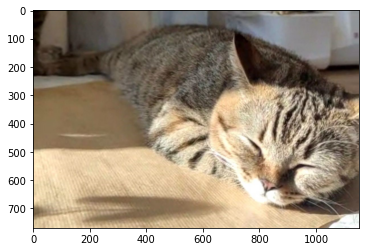

In [ ]:
# covert uploaded byte image into array
byte_image = list(upload.value.values())[0]['content']
image = np.array(Image.open(BytesIO(byte_image)))
plt.imshow(image)

In [ ]:
# segmentation params
compactness = 5
segment_count = 2000
sigma = 3
theshold = 10
color_count = 10
border_color = np.array([50, 50, 50])

## Sementation

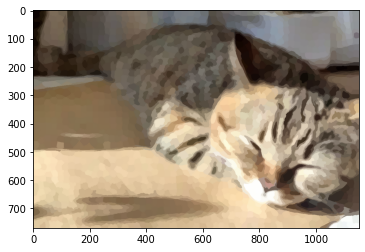

In [ ]:
# segment image
slic_labels = segmentation.slic(image, compactness=compactness,
                            n_segments=segment_count,
                            start_label=1,
                            sigma=sigma)

plt.imshow(color.label2rgb(slic_labels, image, kind='avg', bg_label=0).astype(int))

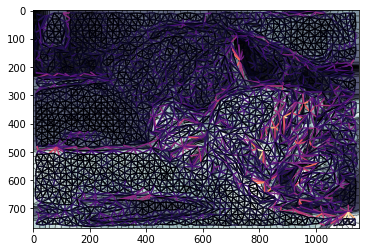

In [ ]:
# construct RAG from segmented image
g = graph.rag_mean_color(image, slic_labels)
graph.show_rag(slic_labels, g, image)

# RAG regions that are similar will be merged
rag_labels = graph.cut_threshold(slic_labels, g, theshold)

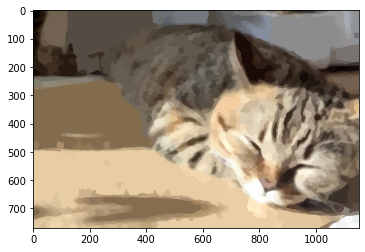

In [ ]:
# show image with grouped colors
rag_img = color.label2rgb(rag_labels, image, kind='avg', bg_label=0).astype(int)
plt.imshow(rag_img)

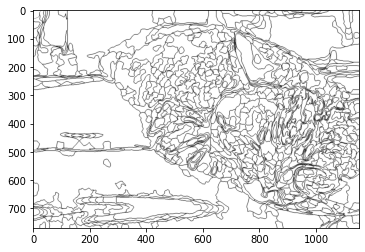

In [ ]:
# show only the segmentation but with numbers acording to the colors
white_image = np.ones_like(image)*255
plt.imshow(mark_boundaries(white_image, rag_labels, border_color/255))


Reduce Color count with K-means Clustering

## Color reduction

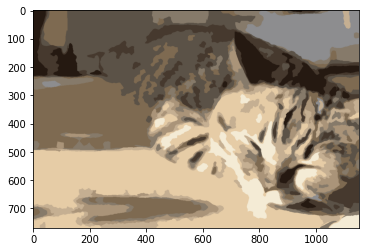

In [ ]:
# kmeans for color reduction
arr = rag_img.reshape((-1, 3))
kmeans = KMeans(n_clusters=color_count).fit(arr)
kmean_labels = kmeans.labels_
centers = kmeans.cluster_centers_
kmeans_img = centers[kmean_labels].reshape(rag_img.shape).astype('int')

plt.imshow(kmeans_img)

In [ ]:
color_labels = np.arange(1, color_count+1)

color_labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

the 10 most common colors in the image


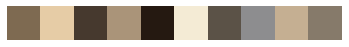

In [ ]:
# show color palette
print(f'the {color_count} most common colors in the image')
plt.imshow([centers.astype('int')])
plt.axis('off')
plt.show()

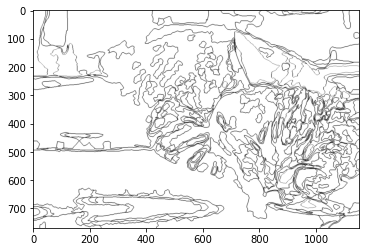

In [ ]:
gray_kmeans = color.rgb2gray(kmeans_img)
min = np.min(gray_kmeans)
max = np.max(gray_kmeans)
normalized_grayscale_img = ((gray_kmeans - min)*(255/(max-min))).astype('int')
kmeans_borders = mark_boundaries(white_image, normalized_grayscale_img, border_color/255)
plt.imshow(kmeans_borders)

## PDF generation

In [ ]:
# https://towardsdatascience.com/creating-pdf-files-with-python-ad3ccadfae0f

Labeling each individual region with the coresponding color number

In [ ]:
"seperate regions into mask images"
print(((gray_kmeans - min)*(255/(max-min))).astype('int'))

"create contours of mask"
# cnt, _ = cv2.findContours(mask, 1, 2)
#     cnt = cnt[0]
#     return cnt

"find a representative point of the shape"
# def get_representative_point(cnt):
#     poly = Polygon(cnt.squeeze())
#     cx = poly.representative_point().x
#     cy = poly.representative_point().y
#     return cx, cy

"draw the specific label on that point"
# # draw on images
# from PIL import Image, ImageDraw

# img = Image.fromarray(np.asarray(kmeans_borders, dtype=np.uint8))
 
# drawable_img = ImageDraw.Draw(img)
# color_number = '1sdasd'
# drawable_img.text((10,10), color_number, fill=tuple(border_color))

# plt.imshow(img) 

[[  0   0   0 ... 130 130 130]
 [  0   0   0 ... 130 130 130]
 [  0   0   0 ... 130 130 130]
 ...
 [193 193 193 ... 215 215 215]
 [193 193 193 ... 215 215 215]
 [193 193 193 ... 215 215 215]]


'draw the specific label on that point'

In [ ]:
# TODOS (next steps)
# - write color identifier to color_palette output
# - for each lable write the cosesponding color nummber in the center of a label
# - instead of writing the code into the center find a space in the region that 
#   would fit the number so that odd shapes do not result in labels being out of
#   bounds

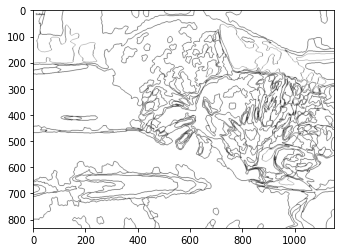

In [ ]:
# draw on images
from PIL import Image, ImageDraw

img = Image.fromarray(np.asarray(kmeans_borders*255, dtype=np.uint8))
 
drawable_img = ImageDraw.Draw(img)
color_number = '1sdasd'
drawable_img.text((10,10), color_number, fill=tuple(border_color))

plt.imshow(img)